In [1]:
# RESEARCH  : CAM INFERENCE RESEARCH
# RESEARCHER: PARK HYUNHO
# UPDATED AT: 2023-11-29
# CREAED AT: 2023-11-29

In [3]:
# IMPORT LIBRARY

import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import torchray.benchmark
from torchray.attribution.grad_cam import grad_cam
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import os 
import json
import sys
sys.path.append('../../')
from random_state import set_seed
sys.path.remove('../../')

set_seed(seed=42)

RANDOM STATE 42 IS STAIBLIZED....


In [64]:
# Get label information from original data
label_dir = '../../../HAM10000/HAM10000_label.csv'
label_df = pd.read_csv(label_dir)
num_classes = len(label_df['label'].unique())
label_mapping = {label: idx for idx, label in enumerate(label_df.iloc[:, 1].unique())}

# Load the locally saved pretrained model
pretrained_model_path = r'C:/Users/MZC01-HYUNHOPART/Desktop/PROJECT/100. PAPER/MODEL/CAM/fine_tune_model/fine_tuned_resnet18_test_0.74%.pth'
pretrained_state_dict = torch.load(pretrained_model_path)
model_architecture = pretrained_model_path.split('/')[-1].split('_')[2]

# Instantiate the model
try:
    # Dynamically load the model class
    model_class = getattr(models, model_architecture)
    model = model_class(weights=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(pretrained_state_dict)

except Exception as e :
    raise ValueError(f'Please check model architecture name which called "{model_architecture}"')

c:\Users\MZC01-HYUNHOPART\anaconda3\envs\cam_model\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [65]:
# set the model to evaluate mode
model.eval()

# Move the model to GPU 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Load an example image for inference and CAM generation
image_path = '../../../HAM10000/images/'
sample_image_lst = [image for image in os.listdir(image_path) if '.jpg' in image]
sample_image_name = sample_image_lst[np.random.randint(0, len(sample_image_lst), 1)[0]]
sample_image = Image.open(image_path + sample_image_name).convert('RGB')    

In [66]:
# Get Mean and Std about MAM10000
with open('../../../HAM10000/HAM10000_MeanStd.json', 'r') as ms_json:
    MeanStd = json.load(ms_json)
    
transform = transforms.Compose([
    transforms.Resize((224, 224)) # ImageNet Trained size
    , transforms.ToTensor()
    , transforms.Normalize(mean=MeanStd['Mean'], std=MeanStd['Std'])
])


In [74]:
# Apply the transformation to the sample image
input_image = transform(sample_image).unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(input_image)
    
# Get the predicted class
predicted_class = torch.argmax(output).item()

# Convert predicted class index to label
predicted_label = next(key for key, value in label_mapping.items() if value == predicted_class)

In [118]:
# Perform CAM (Class Activation Map)
cam = grad_cam(model, input_image, target=predicted_class, saliency_layer='layer4')

# Normalize the CAM
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Convert the CAM to a numpy array
cam_np = cam.cpu().detach().numpy()[0]

# Ensure the CAM is 3 channels
if cam_np.ndim == 2:
    cam_np = np.expand_dims(cam_np, axis=0)  # Add channel dimension if missing

# Upsample the CAM to match the original image size
upsample = transforms.Compose([
    transforms.ToPILImage()
    , transforms.Resize((input_image.shape[2], input_image.shape[3]))
    , transforms.ToTensor()
])

# Convert to 3 channels if needed
if cam_np.shape[0] == 1:
    cam_np = np.concatenate([cam_np] * 3, axis=0)

cam_up = upsample(torch.tensor(cam_np)).numpy()


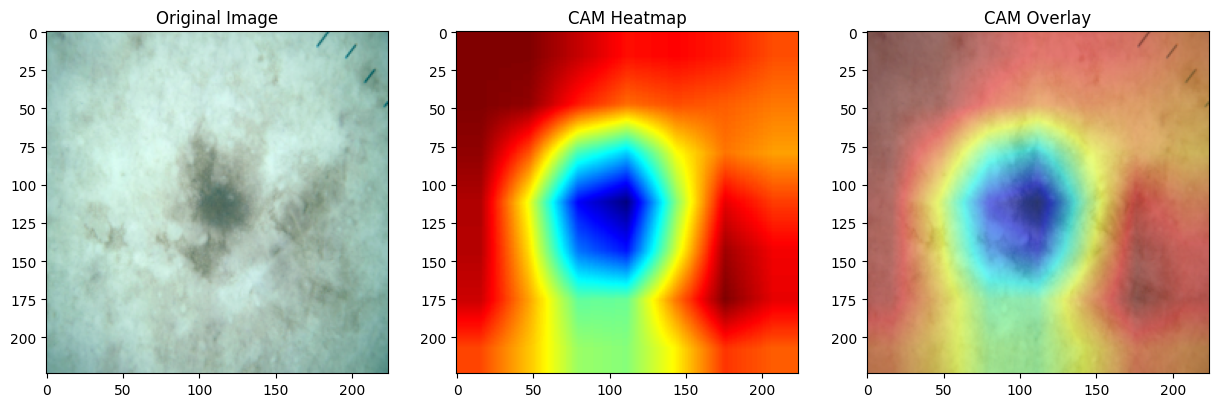

In [130]:
import cv2

# Convert the original image to a NumPy array
input_image_np = input_image.squeeze().cpu().numpy().transpose((1, 2, 0))

# Normalize the original image
input_image_np = (input_image_np - np.min(input_image_np)) / (np.max(input_image_np) - np.min(input_image_np))
input_image_np = (input_image_np * 255).astype(np.uint8)  # Convert to uint8

# Scale the CAM to match the original image size
cam_up_scaled = (cam_up - np.min(cam_up)) / (np.max(cam_up) - np.min(cam_up))
cam_up_scaled = (cam_up_scaled * 255).astype(np.uint8)

# Apply a colormap to the single-channel image
heatmap = cv2.applyColorMap(cam_up_scaled.transpose((1, 2, 0)), cv2.COLORMAP_JET)

# Superimpose the heatmap on the original image
cam_overlay = cv2.addWeighted(input_image_np, 0.5, heatmap, 0.5, 0)  # Specify the data type of the output

# Display the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(input_image_np)
ax[0].set_title('Original Image')

ax[1].imshow(heatmap)
ax[1].set_title('CAM Heatmap')

ax[2].imshow(cam_overlay)
ax[2].set_title('CAM Overlay')

plt.show()
